In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import datetime 
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
from IPython.display import display, clear_output

In [2]:
df= pd.read_csv("CBS_2021-2023_Full .csv")

In [3]:
row_count = len(df)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 1048575


In [4]:
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
ride_length                0
start_station_name     98482
start_station_id       98482
end_station_name      108672
end_station_id        108672
start_lat                  2
start_lng                  2
end_lat                 1634
end_lng                 1634
member_casual              0
dtype: int64

In [5]:
# Drop all rows with any NaN values
df= df.dropna()

In [6]:
df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
ride_length           0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [7]:
df['started_at'] = pd.to_datetime(df['started_at'], format='%d-%m-%Y %H:%M')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='%d-%m-%Y %H:%M')  

In [8]:
df['Month'] = df['started_at'].dt.strftime('%B')
df["year"]=df["started_at"].dt.year
df["start_hour"]=df["started_at"].dt.hour
df["end_hour"]=df["ended_at"].dt.hour
df["day"] = df["started_at"].dt.day
df["day of week"] = df["started_at"].dt.strftime("%A")
df["date_is_weekend"] = np.where(df["day of week"].isin([5, 6]),1,0)

In [9]:
# Calculate trip duration in seconds
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

In [10]:
df['time_of_day'] = df['start_hour'].apply(lambda value: 'Morning' if value in (4,5,6,7,8,9,10,11)
                                                        else 'Afternoon' if value in (12,13,14,15,16)
                                                        else 'Evening' if value in (17,18,19,20,21) 
                                                        else 'Night')

df['time_of_day'] = pd.Categorical(df['time_of_day'],
categories=["Morning","Afternoon","Evening","Night"])

In [11]:
# df.groupby(['member_casual', 'rideable_type'], observed=False)['end_station_id'].apply(lambda x: x.isnull().sum())

In [12]:
# Calculate total rides
total_rides = len(df)

# Calculate casual rides
casual_rides = len(df[df['member_casual'] == 'casual'])

# Calculate casual rider percentage
casual_rider_percentage = (casual_rides / total_rides) * 100

print(f"Casual Rider Percentage: {casual_rider_percentage:.2f}%")

Casual Rider Percentage: 41.62%


In [13]:
row_count = len(df)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 903727


In [14]:
#get the top 10 stations with the highest number of trips using the start station name and ride id
top_start_stations = (df.groupby('start_station_name',observed=False)
                .agg(trip_count=('ride_id', 'count')).nlargest(10, 'trip_count').reset_index())

top_start_stations

,start_station_name,trip_count
0,Lincoln Memorial,12177
1,New Hampshire Ave & T St NW,10852
2,4th St & Madison Dr NW,10067
3,Jefferson Dr & 14th St SW,9952
4,15th & P St NW,9558
5,Henry Bacon Dr & Lincoln Memorial Circle NW,9474
6,Smithsonian-National Mall / Jefferson Dr & 12t...,8233
7,1st & M St NE,7796
8,Thomas Circle,7649
9,14th & Irving St NW,7396


In [15]:
#get the top 10 end stations with the highest number of trips using the end station name and ride id
top_end_stations = (df.groupby('end_station_name',observed=False).agg(trip_count=('ride_id', 'count'))
                .nlargest(10, 'trip_count').reset_index())

top_end_stations

,end_station_name,trip_count
0,Lincoln Memorial,11614
1,New Hampshire Ave & T St NW,10726
2,Jefferson Dr & 14th St SW,10391
3,15th & P St NW,10122
4,4th St & Madison Dr NW,9734
5,Henry Bacon Dr & Lincoln Memorial Circle NW,9418
6,Smithsonian-National Mall / Jefferson Dr & 12t...,8261
7,1st & M St NE,8254
8,14th & V St NW,7766
9,Massachusetts Ave & Dupont Circle NW,7470


In [16]:
popular_stations = pd.concat([top_start_stations, top_end_stations], axis=1)
popular_stations

,start_station_name,trip_count,end_station_name,trip_count
0,Lincoln Memorial,12177,Lincoln Memorial,11614
1,New Hampshire Ave & T St NW,10852,New Hampshire Ave & T St NW,10726
2,4th St & Madison Dr NW,10067,Jefferson Dr & 14th St SW,10391
3,Jefferson Dr & 14th St SW,9952,15th & P St NW,10122
4,15th & P St NW,9558,4th St & Madison Dr NW,9734
5,Henry Bacon Dr & Lincoln Memorial Circle NW,9474,Henry Bacon Dr & Lincoln Memorial Circle NW,9418
6,Smithsonian-National Mall / Jefferson Dr & 12t...,8233,Smithsonian-National Mall / Jefferson Dr & 12t...,8261
7,1st & M St NE,7796,1st & M St NE,8254
8,Thomas Circle,7649,14th & V St NW,7766
9,14th & Irving St NW,7396,Massachusetts Ave & Dupont Circle NW,7470


In [17]:
# Define a function to determine the season based on the month
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        'Autumn'

# Apply the get_season function to the 'Month' column and create a new 'Season' column
df['Season'] = df['Month'].apply(get_season)
df.head(3)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,Month,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,January,2021,0,0,1,Friday,0,1500.0,Night,Winter
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,January,2021,0,0,1,Friday,0,840.0,Night,Winter
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:00,2021-01-01 00:21:00,00:05:35,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,...,January,2021,0,0,1,Friday,0,360.0,Night,Winter


[Text(0.5, 1.0, 'Trip Duration in each Year')]

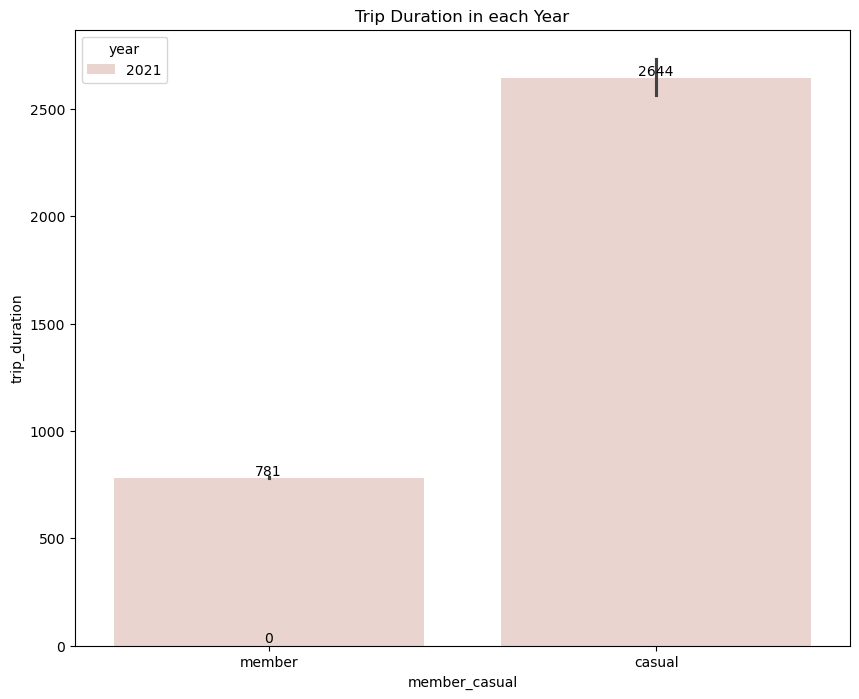

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df, x='member_casual', y='trip_duration', hue= 'year', ax=ax)
for p in ax.patches:
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2
    ax.text(x_position, height + 0.05, f'{int(height)}', ha='center', va='bottom')
ax.set(title='Trip Duration in each Year')

In [19]:
df.groupby(['member_casual', 'rideable_type'], observed=False)['end_station_id'].apply(lambda x: x.isnull().sum())

member_casual  rideable_type
casual         classic_bike     0
               docked_bike      0
               electric_bike    0
member         classic_bike     0
               docked_bike      0
               electric_bike    0
Name: end_station_id, dtype: int64

In [20]:
# Filter for the specific start station name
station_name = 'Columbus Circle / Union Station'
df_filtered = df[df['start_station_name'] == station_name]

# Number of entries for the specific station
df_filtered_count = df_filtered.shape[0]

# Unique start latitude and longitude
num_unique_lat_lng = df_filtered[['start_lat', 'start_lng']].drop_duplicates().shape[0]

# Unique start latitude and longitude
unique_lat_lng = df_filtered[['start_lat', 'start_lng']].drop_duplicates()
unique_lat_lng


,start_lat,start_lng
38,38.896960,-77.004930
2928,38.897183,-77.004755
4657,38.896985,-77.004786
9663,38.897116,-77.004898
10493,38.896983,-77.004776
...,...,...
1043595,38.897110,-77.004845
1043670,38.896982,-77.004766
1044768,38.897064,-77.004932
1045558,38.897210,-77.004987


In [21]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at', 'ride_length',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'Month', 'year', 'start_hour', 'end_hour', 'day',
       'day of week', 'date_is_weekend', 'trip_duration', 'time_of_day',
       'Season'],
      dtype='object')

In [22]:
rides_per_month = df.groupby(['year', 'Month'])['trip_duration'].sum().reset_index()
rides_by_user = df.groupby('member_casual')['trip_duration'].sum()
hourly_usage = df.groupby('Season')['trip_duration'].mean()
print(rides_per_month)
print(rides_by_user)
print(hourly_usage)

   year     Month  trip_duration
0  2021     April    316065960.0
1  2021  February     71396280.0
2  2021   January    108612780.0
3  2021      June    318848340.0
4  2021     March    244829040.0
5  2021       May    347218800.0
member_casual
casual    994526460.0
member    412444740.0
Name: trip_duration, dtype: float64
Season
Spring    1636.677528
Summer    1607.365842
Winter    1196.009913
Name: trip_duration, dtype: float64


In [23]:
# Group by month and calculate casual rider percentage for each month
monthly_casual_ridership = df.groupby(['year', 'Month'])['member_casual'].apply(lambda x: (x == 'casual').sum() / len(x) * 100).reset_index(name='casual_percentage')

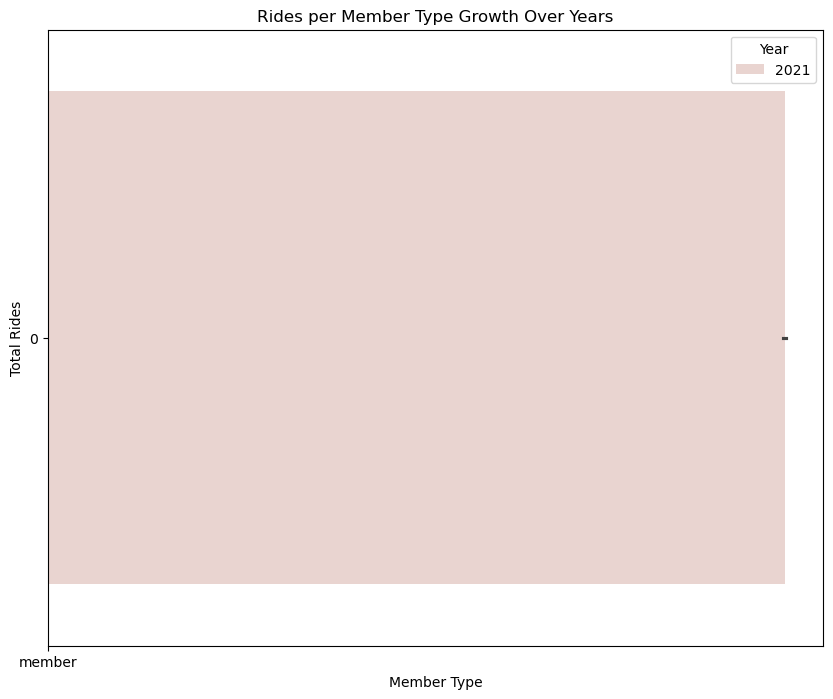

In [24]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df, x='member_casual', hue= 'year', ax=ax)
ax.set(title='Rides per Member Type Growth Over Years')
plt.xlabel('Member Type')
plt.ylabel('Total Rides')
plt.legend(title='Year', loc='upper right')
# Use FuncFormatter to format the y-axis to display full numbers
def format_func(value, tick_number):
    return f'{int(value):,}'  # Add commas for thousands separation

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [25]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,Month,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,January,2021,0,0,1,Friday,0,1500.0,Night,Winter
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,January,2021,0,0,1,Friday,0,840.0,Night,Winter


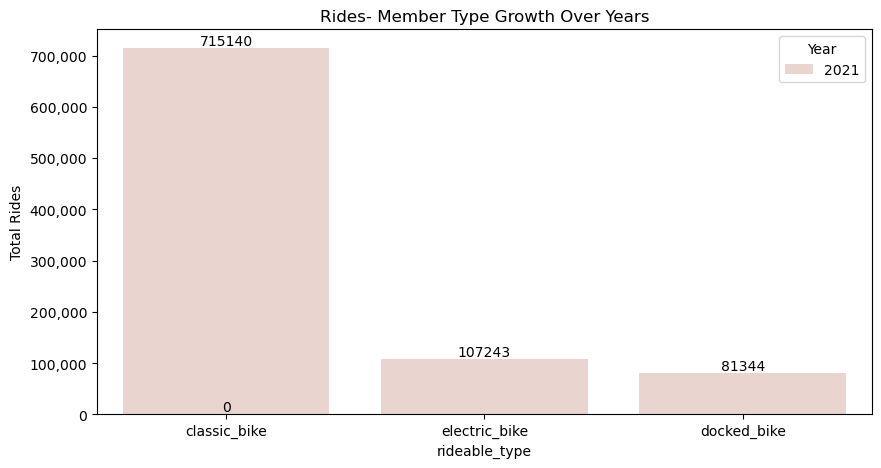

In [26]:
plt.figure(figsize=(10, 5))
plt.title('Rides- Member Type Growth Over Years')
ax = sns.countplot(data=df, x='rideable_type', hue='year')
for p in ax.patches:
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2
    ax.text(x_position, height + 0.05, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('rideable_type')
plt.ylabel('Total Rides')
plt.legend(title='Year', loc='upper right')
def format_func(value, tick_number):
    return f'{int(value):,}' 

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

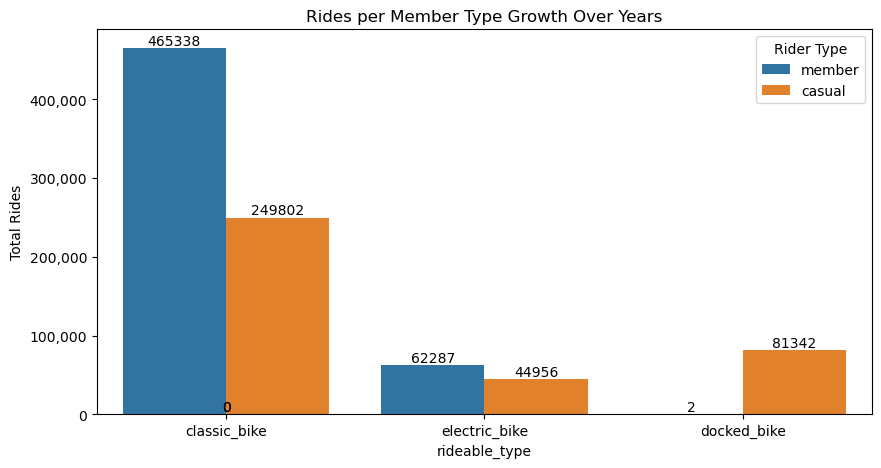

In [27]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(10, 5))
plt.title('Rides per Member Type Growth Over Years')

ax = sns.countplot(data=df, x='rideable_type', hue='member_casual')
for p in ax.patches:
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2
    ax.text(x_position, height + 0.05, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('rideable_type')
plt.ylabel('Total Rides')
plt.legend(title='Rider Type', loc='upper right')
def format_func(value, tick_number):
    return f'{int(value):,}' 

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [28]:
# 1. Identify casual riders who took multiple rides (potential for conversion)
frequent_casual = df[df['member_casual'] == 'casual'].groupby('ride_id').size().reset_index(name='ride_count')
frequent_casual = frequent_casual[frequent_casual['ride_count'] > 2]  # Example: More than 2 rides

In [29]:
# 2. Analyze their riding patterns (where they start/end, time of day, etc.)
frequent_casual_data = df[df['ride_id'].isin(frequent_casual['ride_id'])]
frequent_casual_data

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,Month,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season


In [30]:
# Popular start stations for frequent casual riders
popular_start_stations = frequent_casual_data['start_station_name'].value_counts().head(10)
print("Popular Start Stations for Frequent Casual Riders:\n", popular_start_stations)


Popular Start Stations for Frequent Casual Riders:
 Series([], Name: count, dtype: int64)


In [31]:
# Time of day they ride
time_of_day_usage = frequent_casual_data['time_of_day'].value_counts().sort_index()
print("\nTime of Day Usage for Frequent Casual Riders:\n", time_of_day_usage)


Time of Day Usage for Frequent Casual Riders:
 time_of_day
Morning      0
Afternoon    0
Evening      0
Night        0
Name: count, dtype: int64


In [32]:
member_trips = df[df['member_casual'] == 'member'].groupby(['ride_id', 'Month','year']).agg({'ride_id': 'count'}).rename(columns={'ride_id': 'trip_count'}).reset_index()

In [33]:
# # Group by member and month, count rides
# member_trips = df[df['member_casual'] == 'member'].groupby(['ride_id', 'Month','year']).size().reset_index(name='trip_count')

In [34]:
# Calculate average trips per member per month
average_member_trips = member_trips.groupby('ride_id')['trip_count'].mean().mean()  # Average of averages
print(f"Average Member Trips per Month: {average_member_trips:.2f}")

Average Member Trips per Month: 1.00


In [35]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,Month,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,January,2021,0,0,1,Friday,0,1500.0,Night,Winter
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,January,2021,0,0,1,Friday,0,840.0,Night,Winter


In [36]:
#Trips by day of week for members
member_trips_dayofweek = df[df['member_casual'] == 'member']['day of week'].value_counts().sort_index()
print("\nMember Trips by Day of Week:\n", member_trips_dayofweek)



Member Trips by Day of Week:
 day of week
Friday       77432
Monday       67015
Saturday     82634
Sunday       68002
Thursday     76389
Tuesday      79714
Wednesday    76441
Name: count, dtype: int64


In [37]:
# Casual Rider Repeat Rate by Location:

casual_rides = df[df['member_casual'] == 'casual']
casual_rides['start_station_name'].replace('', np.nan, inplace=True)
casual_rides['end_station_name'].replace('', np.nan, inplace=True)
repeat_riders = casual_rides.groupby(['ride_id', 'start_station_name']).size().reset_index(name='ride_count')
repeat_riders = repeat_riders[repeat_riders['ride_count'] > 1]  # Riders using the same start station more than once

repeat_rate_by_location = repeat_riders.groupby('start_station_name')['ride_id'].count() / casual_rides['start_station_name'].value_counts() * 100
print("Casual Rider Repeat Rate by Location:\n", repeat_rate_by_location)

Casual Rider Repeat Rate by Location:
 start_station_name
10th & E St NW                                         NaN
10th & Florida Ave NW                                  NaN
10th & G St NW                                         NaN
10th & K St NW                                         NaN
10th & Monroe St NE                                    NaN
                                                        ..
Wisconsin Ave & O St NW                                NaN
Woodglen Dr & Executive Blvd                           NaN
Woodley Park Metro / Calvert St & Connecticut Ave NW   NaN
Woodmont Ave & Strathmore St                           NaN
Yuma St & Tenley Circle NW                             NaN
Length: 639, dtype: float64


In [38]:
end_repeat_riders = casual_rides.groupby(['ride_id', 'end_station_name']).size().reset_index(name='ride_count')
end_repeat_riders = repeat_riders[repeat_riders['ride_count'] > 1]  # Riders using the same start station more than once

In [39]:
# repeat_rate_by_location = end_repeat_riders.groupby('end_station_name')['ride_id'].count() / casual_rides['end_station_name'].value_counts() * 10
# print("Casual Rider Repeat Rate by Location:\n", repeat_rate_by_location)

In [40]:
# Station Popularity Index for Casual Riders:

station_popularity = casual_rides['start_station_name'].value_counts()
print("\nStation Popularity Index for Casual Riders:\n", station_popularity)


Station Popularity Index for Casual Riders:
 start_station_name
Lincoln Memorial                                         9742
Jefferson Dr & 14th St SW                                8053
Henry Bacon Dr & Lincoln Memorial Circle NW              7720
4th St & Madison Dr NW                                   7466
Smithsonian-National Mall / Jefferson Dr & 12th St SW    6427
                                                         ... 
Ridge Rd Community Center                                   8
Towers Crescent Dr & Tysons One Pl                          7
Crescent Rd & Ridge Rd                                      5
N Moore St & Rosslyn Metro                                  1
Greenbelt Station Parkway                                   1
Name: count, Length: 639, dtype: int64


In [41]:
df[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name      640
end_station_name        640
start_station_id       1232
end_station_id         1227
start_lat             79327
dtype: int64

In [42]:
# Distance Traveled by Casual vs. Members:

# Calculate distance (Haversine formula for more accuracy)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance


In [43]:
df['distance'] = df.apply(lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)


In [44]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season,distance
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,2021,0,0,1,Friday,0,1500.0,Night,Winter,4.367593
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,2021,0,0,1,Friday,0,840.0,Night,Winter,1.138843


Analysis

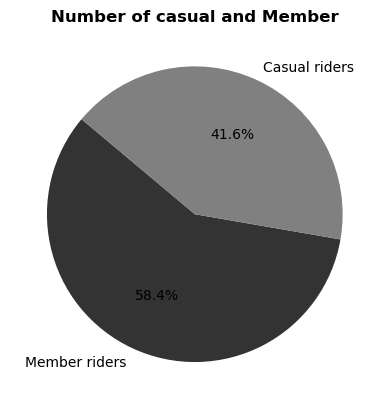

member_casual
member    527627
casual    376100
Name: count, dtype: int64


In [45]:
labels = 'Member riders', 'Casual riders'
colors = ['.2', '.5']
members = df['member_casual'].value_counts()
#Plot a pie chart showing the number of riders
plt.pie(members, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Number of casual and Member', fontsize = 12, fontweight="bold")
plt.show()
print(df['member_casual'].value_counts())

In [46]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season,distance
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,2021,0,0,1,Friday,0,1500.0,Night,Winter,4.367593
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,2021,0,0,1,Friday,0,840.0,Night,Winter,1.138843


In [81]:
df[['ride_id', 'trip_duration']].head()

,ride_id,trip_duration
0,5CB9DFCECF79AF84,1500.0
2,E74069873161EE33,840.0
3,91F95E512CABC46A,360.0
4,DA46A05139C0EA2F,240.0
6,0535306B61EF92F9,1020.0


In [47]:
df.head(3)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season,distance
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,2021,0,0,1,Friday,0,1500.0,Night,Winter,4.367593
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,2021,0,0,1,Friday,0,840.0,Night,Winter,1.138843
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:00,2021-01-01 00:21:00,00:05:35,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,...,2021,0,0,1,Friday,0,360.0,Night,Winter,0.000000


In [48]:
# Casual Riders in High-Traffic Areas:
high_traffic_stations = station_popularity.nlargest(10)  # Top 10 stations
casuals_in_high_traffic = casual_rides[casual_rides['start_station_name'].isin(high_traffic_stations.index)]
print("\nCasual Riders in High-Traffic Areas:\n", casuals_in_high_traffic)


Casual Riders in High-Traffic Areas:
                   ride_id rideable_type          started_at  \
11       DA579474AAD89387  classic_bike 2021-01-01 00:24:00   
12       1DE392338FF58AC7  classic_bike 2021-01-01 00:24:00   
13       64D4C859EC0B8D60  classic_bike 2021-01-01 00:24:00   
18       6B4631D4B1BCB9BB   docked_bike 2021-01-01 00:26:00   
30       3AF0E3F8583D6852  classic_bike 2021-01-01 00:44:00   
...                   ...           ...                 ...   
1048555  F418B5BD7615552E  classic_bike 2021-06-26 00:06:00   
1048569  BEFD0A416BCC2D4E  classic_bike 2021-06-26 00:08:00   
1048570  293926021F7CB636  classic_bike 2021-06-26 00:08:00   
1048572  C5A7AE4B1D09B794  classic_bike 2021-06-26 00:08:00   
1048573  270904164950CEF9  classic_bike 2021-06-26 00:08:00   

                   ended_at ride_length  \
11      2021-01-01 00:47:00    00:23:35   
12      2021-01-01 00:47:00    00:23:42   
13      2021-01-01 00:48:00    00:24:05   
18      2021-01-01 00:47:00    0

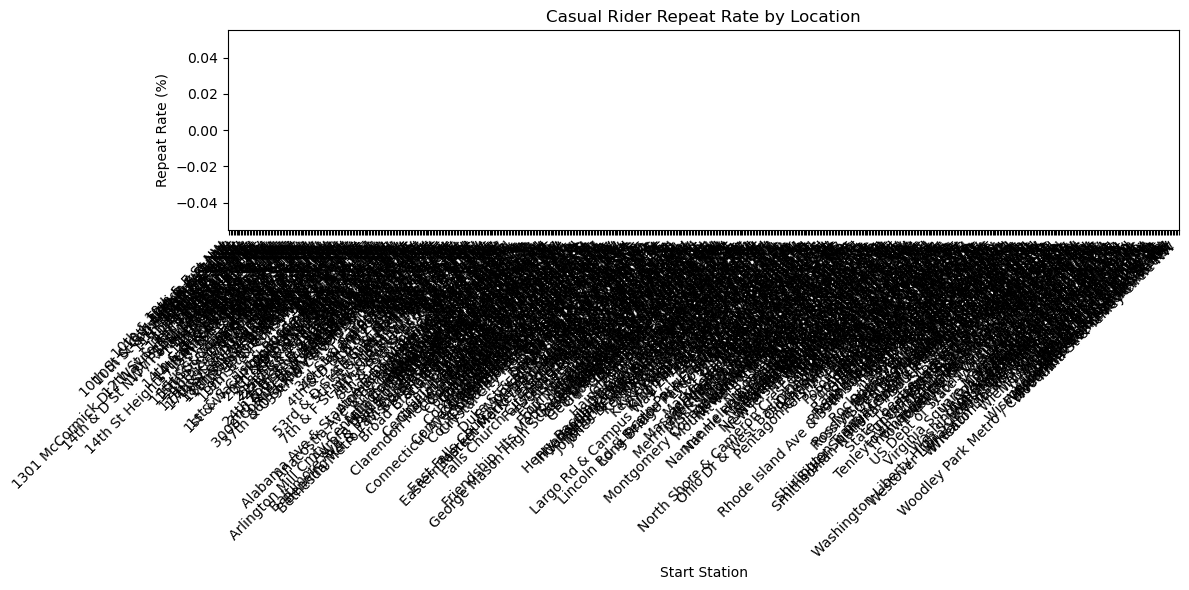

In [49]:
# Visualizing repeat rate by location
plt.figure(figsize=(12, 6))
repeat_rate_by_location.plot(kind='bar')
plt.title('Casual Rider Repeat Rate by Location')
plt.xlabel('Start Station')
plt.ylabel('Repeat Rate (%)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [50]:
df.head(3)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season,distance
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,2021,0,0,1,Friday,0,1500.0,Night,Winter,4.367593
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,2021,0,0,1,Friday,0,840.0,Night,Winter,1.138843
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:00,2021-01-01 00:21:00,00:05:35,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,...,2021,0,0,1,Friday,0,360.0,Night,Winter,0.000000


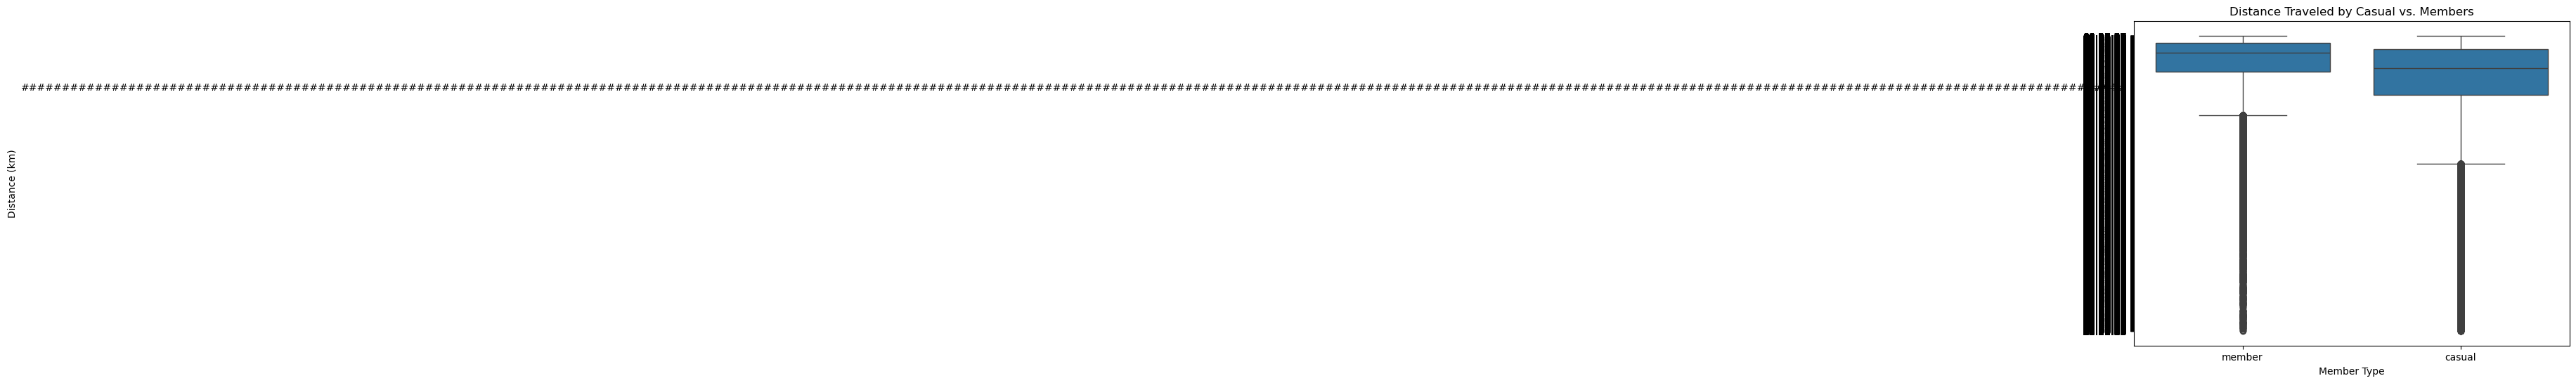

In [51]:
# Example: Visualizing distance comparison
plt.figure(figsize=(8, 6))
sns.boxplot(x='member_casual', y='ride_length', data=df)
plt.title('Distance Traveled by Casual vs. Members')
plt.xlabel('Member Type')
plt.ylabel('Distance (km)')
plt.show()

In [52]:
df['trip_duration'] = pd.to_numeric(df['trip_duration'], errors='coerce')
# KPIs
total_rides = df.shape[0]
avg_trip_duration = df['trip_duration'].mean()

rides_by_member_type = df['member_casual'].value_counts()

rides_by_time_of_day = df['time_of_day'].value_counts()

rides_by_season = df['Season'].value_counts()

peak_start_hour = df['start_hour'].value_counts().idxmax()

peak_end_hour = df['end_hour'].value_counts().idxmax()   

In [53]:
# Weekend vs. Weekday Usage
# weekend_rides = df[df['date_is_weekend'] == True].shape[0]
# weekday_rides = df[df['date_is_weekend'] == False].shape[0]

In [54]:
# Top start and end stations
top_start_stations = df['start_station_name'].value_counts().head(15)
top_end_stations = df['end_station_name'].value_counts().head(15)

In [55]:
# Print KPIs
print(f"Total Rides: {total_rides}")
print(f"Average Trip Duration: {avg_trip_duration:.2f} minutes")

Total Rides: 903727
Average Trip Duration: 1556.85 minutes


In [56]:
print("Rides by Member Type:")
print(rides_by_member_type)

Rides by Member Type:
member_casual
member    527627
casual    376100
Name: count, dtype: int64


In [57]:
print("Rides by Time of Day:")
print(rides_by_time_of_day)
print("Rides by Season:")
print(rides_by_season)

Rides by Time of Day:
time_of_day
Afternoon    346493
Evening      287132
Morning      219286
Night         50816
Name: count, dtype: int64
Rides by Season:
Season
Spring    554852
Summer    198367
Winter    150508
Name: count, dtype: int64


In [58]:
print(f"Peak Start Hour: {peak_start_hour}")
print(f"Peak End Hour: {peak_end_hour}")

Peak Start Hour: 17
Peak End Hour: 17


In [59]:
# print(f"Weekend Rides: {weekend_rides}, Weekday Rides: {weekday_rides}")

In [60]:
print("Top 15 Start Stations:")
print(top_start_stations)

Top 15 Start Stations:
start_station_name
Lincoln Memorial                                         12177
New Hampshire Ave & T St NW                              10852
4th St & Madison Dr NW                                   10067
Jefferson Dr & 14th St SW                                 9952
15th & P St NW                                            9558
Henry Bacon Dr & Lincoln Memorial Circle NW               9474
Smithsonian-National Mall / Jefferson Dr & 12th St SW     8233
1st & M St NE                                             7796
Thomas Circle                                             7649
14th & Irving St NW                                       7396
14th & V St NW                                            7151
Jefferson Memorial                                        7151
11th & M St NW                                            7045
17th St & Independence Ave SW                             6956
8th & O St NW                                             6949
Name: count, 

In [61]:
print("Top 15 End Stations:")
print(top_end_stations)

Top 15 End Stations:
end_station_name
Lincoln Memorial                                         11614
New Hampshire Ave & T St NW                              10726
Jefferson Dr & 14th St SW                                10391
15th & P St NW                                           10122
4th St & Madison Dr NW                                    9734
Henry Bacon Dr & Lincoln Memorial Circle NW               9418
Smithsonian-National Mall / Jefferson Dr & 12th St SW     8261
1st & M St NE                                             8254
14th & V St NW                                            7766
Massachusetts Ave & Dupont Circle NW                      7470
Jefferson Memorial                                        7171
3rd & M St NE                                             7140
8th & O St NW                                             7020
5th & K St NW                                             6932
17th St & Independence Ave SW                             6840
Name: count, dtyp

In [62]:
# repeat_riders_type = repeat_riders.groupby('rideable_type')['ride_id'].count()
# print("\nRepeat Riders by Rideable Type:\n", repeat_riders_type)

# # Visualization:
# plt.figure(figsize=(8, 6))
# repeat_riders_type.plot(kind='bar')
# plt.title('Repeat Riders by Rideable Type')
# plt.xlabel('Rideable Type')
# plt.ylabel('Number of Repeat Riders')
# plt.show()

In [63]:
# repeat_riders_time = casual_rides[casual_rides['ride_id'].isin(repeat_riders['ride_id'])].groupby(['time_of_day', 'day of week'])['ride_id'].count().unstack()
# print("\nRepeat Riders Time of Day and Day of Week:\n", repeat_riders_time)

# # Visualization (heatmap):
# plt.figure(figsize=(10, 8))
# sns.catplot(repeat_riders_time)
# plt.title('Repeat Riders: Time of Day vs. Day of Week')
# plt.xlabel('Day of Week')
# plt.ylabel('Time of Day')
# plt.show()

In [64]:
# plt.figure(figsize=(10, 6))
# sns.histplot(df, x='trip_duration', hue='member_casual', kde=True, bins=50)  # Adjust bins as needed
# plt.title('Trip Duration Distribution')
# plt.xlabel('Trip Duration (seconds)')
# plt.ylabel('Frequency')
# plt.show()

Station Usages in Morning Time

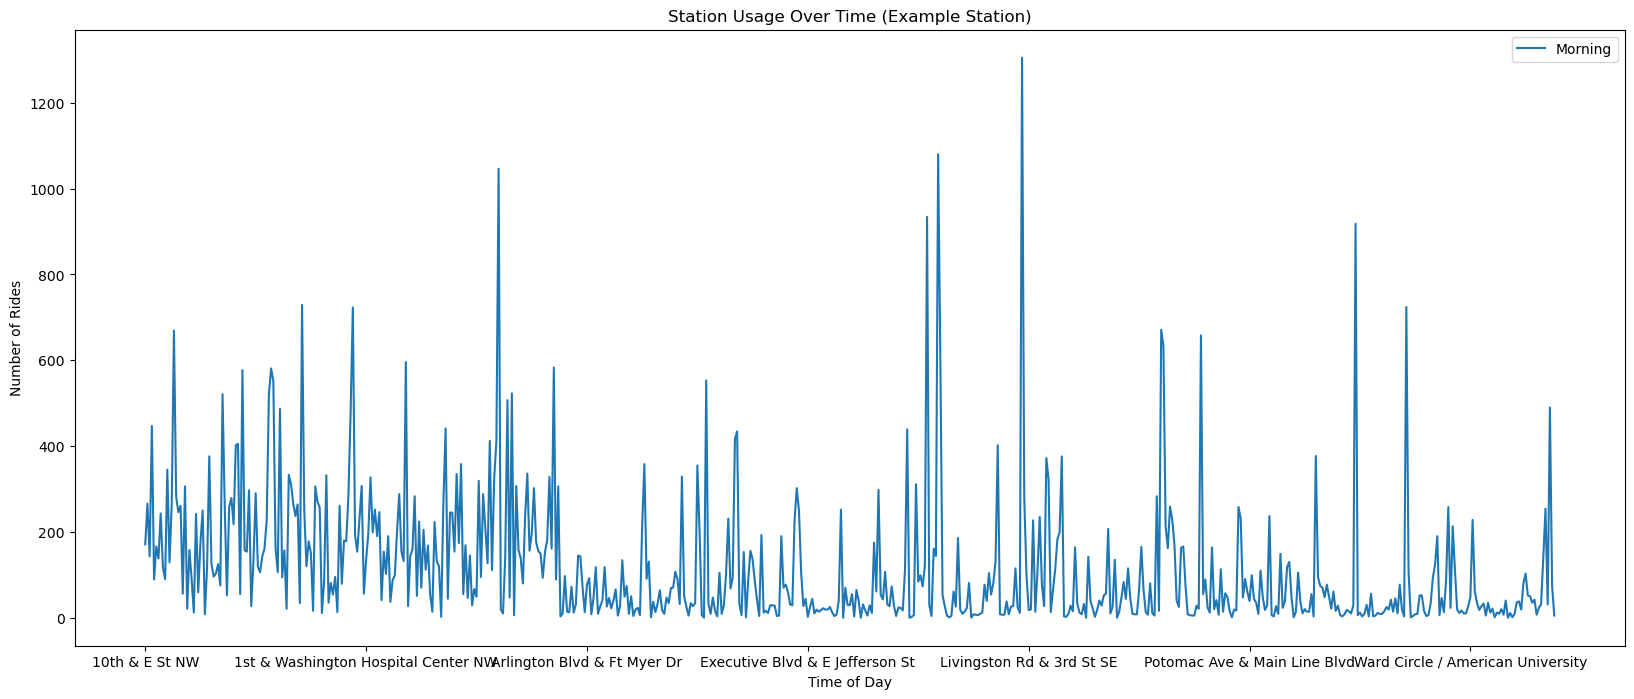

In [65]:
station_usage_over_time = casual_rides.groupby(['start_station_name', 'time_of_day'])['ride_id'].count().unstack()

# Visualization (example for one station - repeat for other key stations):
plt.figure(figsize=(20, 8))
station_usage_over_time['Morning'].plot(label='Morning') #Example time of day
# station_usage_over_time['Afternoon'].plot(label='Afternoon') #Example time of day
plt.title('Station Usage Over Time (Example Station)')
plt.xlabel('Time of Day')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

Station Usages in Afternoon Time

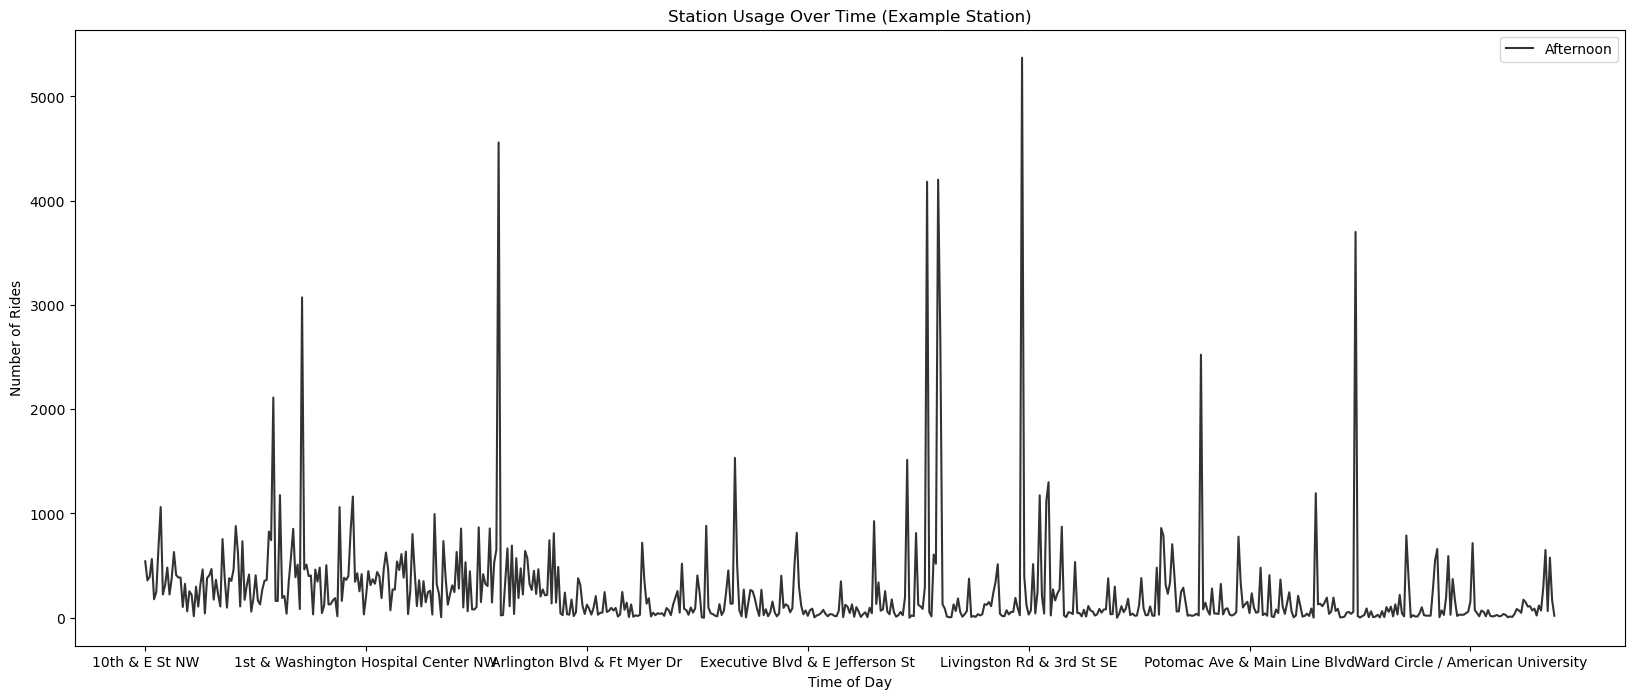

In [66]:
station_usage_over_time = casual_rides.groupby(['start_station_name', 'time_of_day'])['ride_id'].count().unstack()

# Visualization (example for one station - repeat for other key stations):
plt.figure(figsize=(20, 8))
# station_usage_over_time['Morning'].plot(label='Morning') #Example time of day
station_usage_over_time['Afternoon'].plot(label='Afternoon', color= '.2') #Example time of day
plt.title('Station Usage Over Time (Example Station)')
plt.xlabel('Time of Day')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

KPI 

In [67]:
row_count = len(df)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 903727


In [68]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,ride_length,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,year,start_hour,end_hour,day,day of week,date_is_weekend,trip_duration,time_of_day,Season,distance
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:00,2021-01-01 00:33:00,00:25:20,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,...,2021,0,0,1,Friday,0,1500.0,Night,Winter,4.367593
2,E74069873161EE33,electric_bike,2021-01-01 00:14:00,2021-01-01 00:28:00,00:14:13,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,...,2021,0,0,1,Friday,0,840.0,Night,Winter,1.138843


In [82]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at', 'ride_length',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'Month', 'year', 'start_hour', 'end_hour', 'day',
       'day of week', 'date_is_weekend', 'trip_duration', 'time_of_day',
       'Season', 'distance'],
      dtype='object')

In [88]:
import geopandas as gpd  # Import geopandas and give it the alias 'gpd'
import pandas as pd # You'll likely need pandas as well to work with dataframes

ModuleNotFoundError: No module named 'geopandas'

In [87]:
df_end=df[['end_station_name','end_station_id', 'end_lat', 'end_lng']]
df_end

wards= gpd.read_file('Wards_from_2022.geojson') 

NameError: name 'gpd' is not defined

In [ ]:
df_start=df[['start_station_name', 'start_station_id', 'start_lat', 'start_lng' ]]
df_start

,start_station_name,start_station_id,start_lat,start_lng
0,Maine Ave & 9th St SW,31646.0,38.880440,-77.025236
2,17th & Corcoran St NW,31214.0,38.912138,-77.038568
3,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563
4,11th & Park Rd NW,31651.0,38.931322,-77.028247
6,Bladensburg Rd & Benning Rd NE,31617.0,38.900413,-76.982872
...,...,...,...,...
1048570,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,38.888774,-77.028694
1048571,Georgetown Harbor / 30th St NW,31215.0,38.902314,-77.059141
1048572,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,38.888774,-77.028694
1048573,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,38.888774,-77.028694


In [69]:
df[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name      640
end_station_name        640
start_station_id       1232
end_station_id         1227
start_lat             79327
dtype: int64

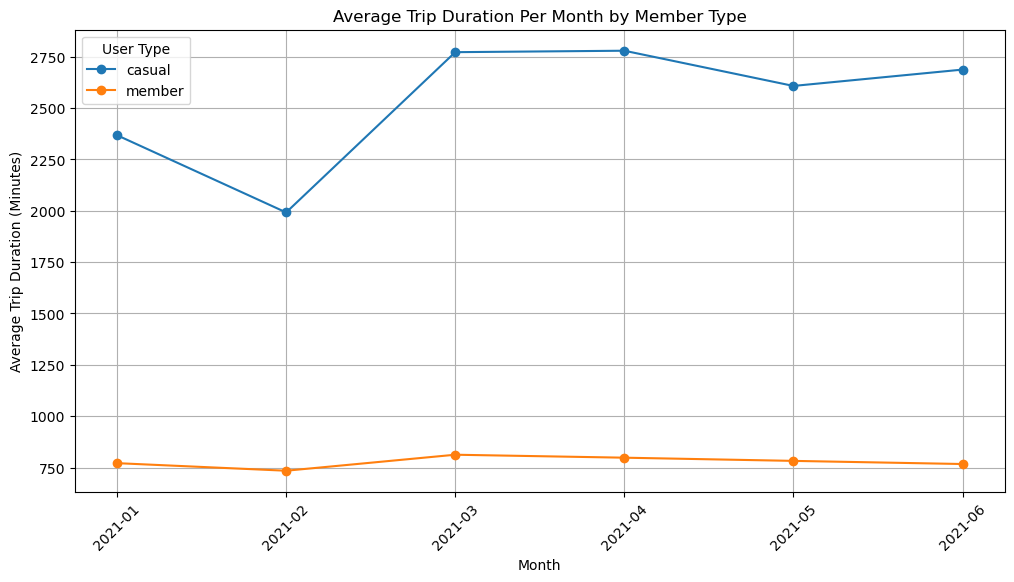

In [70]:
# Resample data by month and member type, then compute the average trip duration
avg_duration_monthly = df.groupby([df['started_at'].dt.to_period('M'), 'member_casual'],observed=False)['trip_duration'].mean().unstack()

# Plot the line graph with months on the x-axis for each member type
plt.figure(figsize=(12, 6))
for member_type in avg_duration_monthly.columns:
    plt.plot(avg_duration_monthly.index.astype(str), avg_duration_monthly[member_type], marker='o', linestyle='-', label=member_type)

plt.xlabel("Month")
plt.ylabel("Average Trip Duration (Minutes)")
plt.title("Average Trip Duration Per Month by Member Type")
plt.xticks(rotation=45)
plt.legend(title="User Type")
plt.grid(True)
plt.show()

Calculate Average Trip Duration for Each Member Type

In [71]:
import numpy as np
import folium
from folium import plugins

In [72]:
m=folium.Map()
m

In [73]:
# After that, we can immediately set on creating a map
m=folium.Map()

# By default it will show the world map zoomed out all the way. We can
# remedy that by passing arguments.

m=folium.Map(location=[38.880440 , -77.025236],   # Our map view centrepoint. In our case, Berlin.
                zoom_start=12,              # Starting zoom step
                max_zoom=26,                # Maximum zooming step
                min_zoom=2)   
m

In [74]:
m=folium.Map(location=[ 38.889805, -77.009056 ], zoom_start=12, min_zoom=9)

folium.Marker([38.888255, -77.049437]).add_to(m) # We will add a marker at the specified coordinates 
folium.Marker([38.888553, -77.032427]).add_to(m) 
folium.Marker([38.890539, -77.049383]).add_to(m)  
folium.Marker([38.888774, -77.028694]).add_to(m)  
folium.Marker([38.888097, -77.038325]).add_to(m)  
folium.Marker([38.892244, -77.033234]).add_to(m)  
m

In [75]:
m=folium.Map(location=[ 38.889805, -77.009056 ], zoom_start=12, min_zoom=9)
# We will add a marker at the specified coordinates 
folium.Marker([38.888255, -77.049437], popup ="Lincoln Memorial").add_to(m) 
folium.Marker([38.888553, -77.032427], popup ="Jefferson Dr & 14th St SW ").add_to(m) 
folium.Marker([38.890539, -77.049383], popup ="14th St & New York Ave NW").add_to(m)  
folium.Marker([38.888774, -77.028694], popup= "Smithsonian-National Mall / Jefferson Dr & 12th St SW").add_to(m)  
folium.Marker([38.888097, -77.038325], popup="17th St & Independence Ave SW").add_to(m)  
folium.Marker([38.892244, -77.033234], popup="15th St & Constitution Ave NW").add_to(m)
m

Top 15 Start Stations and Bike Usages with Stations

In [76]:
# Top 15 Start Stations
m=folium.Map(location=[ 38.889805, -77.009056 ], zoom_start=12, min_zoom=9)
# We will add a marker at the specified coordinates 
folium.Marker([38.915544, -77.038252], popup ="New Hampshire Ave & T St NW -102179").add_to(m)
folium.Marker([38.89696, -77.00493], popup ="Columbus Circle / Union Station -100584").add_to(m)
folium.Marker([38.888255, -77.0494365], popup ="Lincoln Memorial -96667").add_to(m)
folium.Marker([38.909892, -77.034337], popup ="15th & P St NW -95670").add_to(m)
folium.Marker([38.888553, -77.032427], popup ="Jefferson Dr & 14th St SW -88078").add_to(m)
folium.Marker([38.905746, -77.005568], popup ="1st & M St NE -85552").add_to(m)
folium.Marker([38.8904955, -77.0172465], popup ="4th St & Madison Dr NW -83831").add_to(m)
folium.Marker([38.90304, -77.019027], popup ="5th & K St NW -76586").add_to(m)
folium.Marker([38.888774, -77.028694], popup ="Smithsonian-National Mall / Jefferson Dr & 12th St SW -76452").add_to(m)
folium.Marker([38.890539, -77.049383], popup ="Henry Bacon Dr & Lincoln Memorial Circle NW -76236").add_to(m)
folium.Marker([38.9177645, -77.032096], popup ="14th & V St NW -75868").add_to(m) 
folium.Marker([38.88426009, -76.9947356], popup ="Eastern Market Metro / Pennsylvania Ave & 8th St SE -75397").add_to(m)
folium.Marker([38.91012967, -77.04420567], popup ="Massachusetts Ave & Dupont Circle NW -72609").add_to(m)
folium.Marker([38.90864, -77.02277], popup ="8th & O St NW -68040").add_to(m)
folium.Marker([38.913046, -77.032008], popup ="14th & R St NW -67332").add_to(m)
m


Top 15 End Stations and Bike Usages Stations

In [77]:
# Top 15 End Stations
m=folium.Map(location=[ 38.889805, -77.009056 ], zoom_start=12, min_zoom=9)
# We will add a marker at the specified coordinates 
folium.Marker([38.89696, -77.00493], popup ="Columbus Circle / Union Station -102410").add_to(m)
folium.Marker([38.915544, -77.038252], popup ="New Hampshire Ave & T St NW -100880").add_to(m)
folium.Marker([38.90980063, -77.03442693], popup ="15th & P St NW -96758").add_to(m)
folium.Marker([38.888255, -77.049437], popup ="Lincoln Memorial -95439").add_to(m)
folium.Marker([38.8885525, -77.032427], popup ="Jefferson Dr & 14th St SW -91470").add_to(m)
folium.Marker([38.905697, -77.005483], popup ="1st & M St NE -87083").add_to(m)
folium.Marker([38.8904955, -77.0172465], popup ="4th St & Madison Dr NW -83007").add_to(m)
folium.Marker([38.888774, -77.028694], popup ="Smithsonian-National Mall / Jefferson Dr & 12th St SW - 78897").add_to(m)
folium.Marker([38.9101, -77.0444], popup ="Massachusetts Ave & Dupont Circle NW -78765").add_to(m)
folium.Marker([38.90304, -77.019027], popup ="5th & K St NW -77980").add_to(m)
folium.Marker([38.890539, -77.049383], popup ="Henry Bacon Dr & Lincoln Memorial Circle NW -76505").add_to(m)
folium.Marker([38.88411367, -76.995287], popup ="Eastern Market Metro / Pennsylvania Ave & 8th St SE -76294").add_to(m)
folium.Marker([38.9177645, -77.032096], popup ="14th & V St NW - 75120").add_to(m)
folium.Marker([38.91299117, -77.03186733], popup ="14th & R St NW -68771").add_to(m)
folium.Marker([38.90864, -77.02277], popup ="8th & O St NW - 67898").add_to(m)
m

In [78]:
# Count trips for each start-to-end station pair
popular_trips = df.groupby(["start_station_name", "end_station_name"]).size().reset_index(name="trip_count")

# Sort by trip count in descending order
popular_trips = popular_trips.sort_values(by="trip_count", ascending=False)

# Display the most popular trips
popular_trips.head(15)

,start_station_name,end_station_name,trip_count
53855,Jefferson Dr & 14th St SW,Jefferson Dr & 14th St SW,1926
70902,Smithsonian-National Mall / Jefferson Dr & 12t...,Smithsonian-National Mall / Jefferson Dr & 12t...,1844
65465,Ohio Dr & West Basin Dr SW / MLK & FDR Memorials,Ohio Dr & West Basin Dr SW / MLK & FDR Memorials,1741
32691,4th St & Madison Dr NW,4th St & Madison Dr NW,1597
52043,Gravelly Point,Gravelly Point,1443
52321,Hains Point/Buckeye & Ohio Dr SW,Hains Point/Buckeye & Ohio Dr SW,1426
12573,15th St & Constitution Ave NW,15th St & Constitution Ave NW,1395
57015,Lincoln Memorial,Lincoln Memorial,1338
15230,17th St & Independence Ave SW,17th St & Independence Ave SW,1265
53122,Henry Bacon Dr & Lincoln Memorial Circle NW,Henry Bacon Dr & Lincoln Memorial Circle NW,1087


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder